# Neural network

### Try to use our own preprocessing

In [627]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA
import warnings
from pathlib import Path

from utils.data_processing import create_feables
from utils.data_processing import confusion_matrix

warnings.simplefilter("ignore")

# You should run the ../../data_preprocessing.ipynb notebook to generate the data before running this
data = pd.read_csv("../../datasets/data.csv")
# data = data.tail(3000)

def normalize_bk_coefs(row, coef_name):
    keys = ['H', 'A', 'D']
    total = 0
    for key in keys:
        total += row[coef_name+key]
    
    for key in keys:
        row[coef_name+key] = row[coef_name+key] / total
    
    return row

# Normalize coefs
bk = ["B365", "BW", "IW", "LB", "WH", "VC"]
for coef_name in bk:
    data = data.apply(lambda row: normalize_bk_coefs(row, coef_name), axis=1)


labels = data.loc[:,'label']
features = data.drop('label', axis = 1)

print('Done')

In [628]:
from sklearn.model_selection import train_test_split


#Splitting the data into train, test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42, shuffle = True, stratify = labels)

# Show some rows of the data
X_train.head()

,Unnamed: 0,season,month,stage,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,...,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
2321,2363.0,2009.0,8.0,2.0,30.0,30.0,30.0,30.0,30.0,30.0,...,0.265060,0.294479,0.398773,0.306748,0.320685,0.403917,0.275398,0.324130,0.390156,0.285714
14423,15306.0,2009.0,8.0,4.0,40.0,50.0,40.0,30.0,40.0,50.0,...,0.404494,0.235294,0.352941,0.411765,0.242938,0.361582,0.395480,0.241379,0.367816,0.390805
7731,8229.0,2012.0,11.0,14.0,65.0,50.0,60.0,45.0,55.0,45.0,...,0.504673,0.141825,0.361337,0.496838,0.141825,0.361337,0.496838,0.153153,0.360360,0.486486
16078,17082.0,2013.0,4.0,33.0,60.0,70.0,70.0,60.0,70.0,70.0,...,0.235294,0.402235,0.368715,0.229050,0.417582,0.357143,0.225275,0.414894,0.372340,0.212766
505,537.0,2010.0,9.0,7.0,70.0,50.0,70.0,60.0,60.0,65.0,...,0.566802,0.093546,0.326323,0.580131,0.085487,0.318091,0.596421,0.079755,0.306748,0.613497


In [629]:
print("Number of wins in test set:", np.sum(y_test == 2))
print("Number of draws in test set:", np.sum(y_test == 1))
print("Number of defeats in test set:", np.sum(y_test == 0))

y_train.head()

Number of wins in test set: 2237
Number of draws in test set: 1230
Number of defeats in test set: 1405


2321     1.0
14423    2.0
7731     2.0
16078    0.0
505      2.0
Name: label, dtype: float64

In [630]:
# Match outcome
y_train.head()

# Number of possible outcomes
# 2 = win
# 1 = draw
# 0 = lose
print('Number of possible outcomes', np.unique(y_train.values).shape[0])
labels = np.unique(y_train.values)
print("Labels:", labels)


Number of possible outcomes 3
Labels: [0. 1. 2.]


In [631]:
# Get number of columns by getting the number of columns in the X_train
columns = X_train.shape[1]
print('Number of columns:', columns)

Number of columns: 31


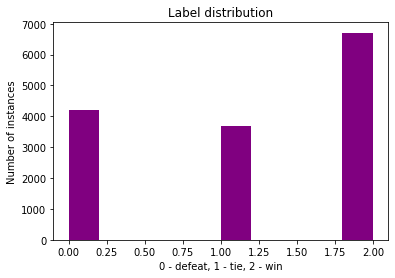

In [632]:
import matplotlib.pyplot as plt

# Plot the distribution of labels in the train data
def plot_labels_histogram(data):
    plt.hist(data, facecolor='purple', align='mid')
    plt.ylabel('Number of instances')
    plt.xlabel('0 - defeat, 1 - tie, 2 - win')
    plt.title("Label distribution")
    
plot_labels_histogram(y_train)

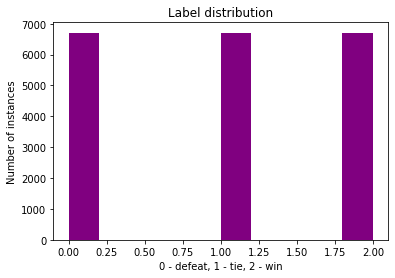

In [633]:
from imblearn.over_sampling import RandomOverSampler

# Since the train data is uneven and the dataset is not "huge" we need to upsamle/oversample
sampler = RandomOverSampler()
X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

# Plot the oversampled train set
plot_labels_histogram(y_train_sampled)

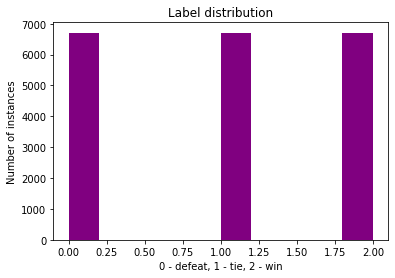

In [634]:
from sklearn.utils import shuffle

# Assign train values with the new sampled data
X_train, y_train = shuffle(X_train_sampled, y_train_sampled, random_state=42)

plot_labels_histogram(y_train)

In [635]:
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Flatten, Dense, Dropout, LeakyReLU
from keras.optimizers import SGD, Adam
from keras import regularizers

model = Sequential() 
model.add(Dense(20, input_dim=columns, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-05), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_341 (Dense)            (None, 20)                640       
_________________________________________________________________
dense_342 (Dense)            (None, 16)                336       
_________________________________________________________________
dense_343 (Dense)            (None, 3)                 51        
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________________


In [636]:
from keras.utils.np_utils import to_categorical

# Convert a class vector (integers) to binary class matrix.
print("Unique labels in the train set: ", np.unique(y_train))
# One hot encoding
y_train_categorical = to_categorical(y_train, num_classes=len(labels))
print("Unique labels in the train set after encoding: ", np.unique(y_train_categorical, axis=0))

print("------------------------------------------------------------------------------------------ \n")
history = model.fit(X_train, y_train_categorical, batch_size=64, epochs=100, validation_split=0.2)

Unique labels in the train set:  [0. 1. 2.]
Unique labels in the train set after encoding:  [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
------------------------------------------------------------------------------------------ 

Train on 16104 samples, validate on 4026 samples
Epoch 1/100
16104/16104 [==============================] - 8s 492us/step - loss: 1.2454 - acc: 0.3325 - val_loss: 1.2381 - val_acc: 0.3251
Epoch 2/100
16104/16104 [==============================] - 1s 60us/step - loss: 1.2038 - acc: 0.3323 - val_loss: 1.1996 - val_acc: 0.3202
Epoch 3/100
16104/16104 [==============================] - 1s 60us/step - loss: 1.1722 - acc: 0.3315 - val_loss: 1.1702 - val_acc: 0.3199
Epoch 4/100
16104/16104 [==============================] - 1s 65us/step - loss: 1.1486 - acc: 0.3317 - val_loss: 1.1485 - val_acc: 0.3207
Epoch 5/100
16104/16104 [==============================] - 1s 63us/step - loss: 1.1317 - acc: 0.3320 - val_loss: 1.1328 - val_acc: 0.3214
Epoch 6/100
16104/16104 [=============

16104/16104 [==============================] - 1s 66us/step - loss: 1.0995 - acc: 0.3343 - val_loss: 1.1000 - val_acc: 0.3351
Epoch 59/100
16104/16104 [==============================] - 1s 62us/step - loss: 1.0995 - acc: 0.3351 - val_loss: 1.1000 - val_acc: 0.3351
Epoch 60/100
16104/16104 [==============================] - 1s 62us/step - loss: 1.0995 - acc: 0.3353 - val_loss: 1.0999 - val_acc: 0.3351
Epoch 61/100
16104/16104 [==============================] - 1s 66us/step - loss: 1.0995 - acc: 0.3277 - val_loss: 1.0998 - val_acc: 0.3351
Epoch 62/100
16104/16104 [==============================] - 1s 69us/step - loss: 1.0994 - acc: 0.3366 - val_loss: 1.0999 - val_acc: 0.3351
Epoch 63/100
16104/16104 [==============================] - 1s 62us/step - loss: 1.0994 - acc: 0.3361 - val_loss: 1.0998 - val_acc: 0.3351
Epoch 64/100
16104/16104 [==============================] - 1s 70us/step - loss: 1.0994 - acc: 0.3330 - val_loss: 1.0998 - val_acc: 0.3351
Epoch 65/100
16104/16104 [==============

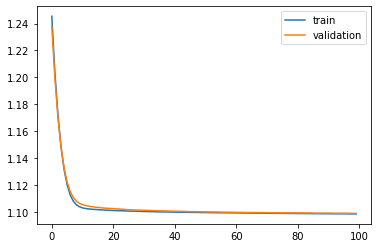

In [637]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

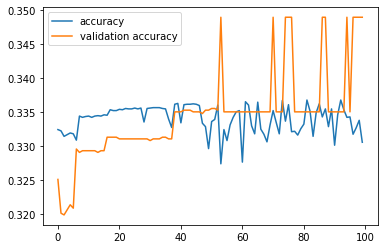

In [638]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [639]:
# Take the most probable prediction
# print(model.predict(X_test))
predictions = np.argmax(model.predict(X_test), axis=1)
print(np.unique(predictions))
# Calculate accuracy
accuracy = (predictions == y_test).mean()
print("Test set accuracy:", accuracy)

[0 1 2]
Test set accuracy: 0.4433497536945813


# Let us plot the confusion matrix

164
[0 1 2]
Neural network confusion matrix: 
                    Home wins (pred)  Draw (pred)  Home loses (pred)
Home wins (true)               2056           64                117
Draw (true)                    1132           43                 55
Home loses (true)              1287           57                 61

 True labels distribution: 



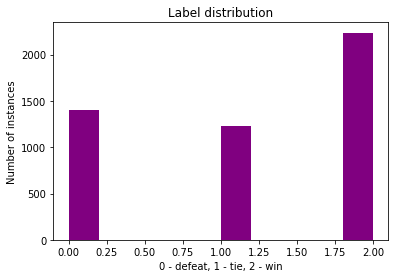

In [640]:
# from utils.data_processing import build_confusion_matrix

# TODO: Remove this and use the commented import instead
def build_confusion_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[2, 1, 0]),
                        index=['Home wins (true)', 'Draw (true)', 'Home loses (true)'],
                        columns=['Home wins (pred)', 'Draw (pred)', 'Home loses (pred)'])

print(np.sum((predictions == 1)))
print(np.unique(predictions))
print("Neural network confusion matrix: \n", build_confusion_matrix(y_test, predictions))


print('\n True labels distribution: \n')
plot_labels_histogram(y_test)

# Comparing Neural network to Random forest

In [ ]:
#Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0, stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.25, random_state = 0, stratify = y_train_calibrate)


In [ ]:
from utils.data_processing import train_calibrate_predict

# Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

# Init Random Forest
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 'dm_reduce__n_components': np.arange(5, feature_len, int(np.around(feature_len/5)))}

#Initializing dimensionality reductions
pca = PCA()
RF_clf.fit(X_train, y_train)

print("Random forest accuracy for train set.".format(RF_clf.__class__.__name__, accuracy_score(y_train, RF_clf.predict(X_train))))
print("Random forest accuracy for test set".format(RF_clf.__class__.__name__, accuracy_score(y_test, RF_clf.predict(X_test))))

#Grid search, calibrate, and test the classifier
calibrated_RF_clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = RF_clf, dm_reduction = pca, X_train = X_train, y_train = y_train,
                                                                  X_calibrate = X_calibrate, y_calibrate = y_calibrate,
                                                                  X_test = X_test, y_test = y_test, cv_sets = cv_sets,
                                                                  params = parameters_RF, scorer = scorer, jobs = 1, use_grid_search = True)

In [ ]:
rf_predictions = RF_clf.predict(X_test)

# Calculate accuracy
accuracy = (rf_predictions == y_test).mean()
print("Random forest test set accuracy:", accuracy)

In [ ]:
print("Random forest confusion matrix: \n", build_confusion_matrix(y_test, rf_predictions))

# Conclusion